In [ ]:
%cd /content/drive/MyDrive/BLIP
!git clone https://github.com/salesforce/BLIP.git

/content/drive/MyDrive/BLIP
Cloning into 'BLIP'...
remote: Enumerating objects: 277, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 277 (delta 137), reused 136 (delta 135), pack-reused 112
Receiving objects: 100% (277/277), 7.03 MiB | 3.12 MiB/s, done.
Resolving deltas: 100% (153/153), done.


In [ ]:
%cd /content/drive/MyDrive/BLIP/BLIP

/content/drive/MyDrive/BLIP/BLIP


In [ ]:
!pip3 install transformers==4.25.1 timm==0.4.12 fairscale==0.4.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 30.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.7 MB/s eta 0:00:00
  Created wheel for fairscale: filename=fairscale-0.4.4-py3-none-any.whl size=292835 sha256=be14810b1d091731d275592e4bfffed450f5313c1b87f11c00345287a33c35ca
  Stored in directory: /root/.cache/pip/wheels/08/58/6f/56c57fa8315eb0bcf0287b580c850845be5f116359b809e9f1
Successfully built fairscale


In [ ]:
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=550730 sha256=82bc3f49308c9c6ba93bb4df0cc47ca75e89788bbf65e2fa42889e49c1de2901
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


In [ ]:
!git clone https://github.com/anminhhung/dog-cat-dataset.git

Cloning into 'dog-cat-dataset'...
remote: Enumerating objects: 25004, done.
remote: Total 25004 (delta 0), reused 0 (delta 0), pack-reused 25004
Receiving objects: 100% (25004/25004), 541.49 MiB | 5.36 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (25001/25001), done.


In [ ]:
from PIL import Image, ImageDraw
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

import os
from glob import glob
from annoy import AnnoyIndex
from IPython.display import display
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image_path, image_size):
  image = Image.open(image_path).convert('RGB')

  transform = transforms.Compose([
    transforms.Resize((image_size, image_size), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    ])
  image = transform(image).unsqueeze(0).to(device)
  return image

In [ ]:
list_image_path = glob(os.path.join('./dog-cat-dataset/data', '*/*/*.jpg'))
len(list_image_path)

25000

###Prepare model

In [ ]:
from models.med import BertConfig, BertModel
from transformers import BertTokenizer

import torch
from torch import nn
import torch.nn.functional as F

from models.blip import create_vit, init_tokenizer, load_checkpoint

class BLIP_ITM(nn.Module):
    def __init__(self,
                 med_config = 'configs/med_config.json',
                 image_size = 384,
                 vit = 'base',
                 vit_grad_ckpt = False,
                 vit_ckpt_layer = 0,
                 embed_dim = 256,
                 ):
        """
        Args:
            med_config (str): path for the mixture of encoder-decoder model's configuration file
            image_size (int): input image size
            vit (str): model size of vision transformer
        """
        super().__init__()

        self.visual_encoder, vision_width = create_vit(vit,image_size, vit_grad_ckpt, vit_ckpt_layer)
        self.tokenizer = init_tokenizer()
        med_config = BertConfig.from_json_file(med_config)
        med_config.encoder_width = vision_width
        self.text_encoder = BertModel(config=med_config, add_pooling_layer=False)

        text_width = self.text_encoder.config.hidden_size

        self.vision_proj = nn.Linear(vision_width, embed_dim)
        self.text_proj = nn.Linear(text_width, embed_dim)

        self.itm_head = nn.Linear(text_width, 2)


    def forward(self, image, caption, match_head='itm'):
        image_embeds = self.visual_encoder(image)
        image_atts = torch.ones(image_embeds.size()[:-1],dtype=torch.long).to(image.device)

        text = self.tokenizer(caption, padding='max_length', truncation=True, max_length=35,
                              return_tensors="pt").to(image.device)

        if match_head=='itm':
            output = self.text_encoder(text.input_ids,
                                       attention_mask = text.attention_mask,
                                       encoder_hidden_states = image_embeds,
                                       encoder_attention_mask = image_atts,
                                       return_dict = True,
                                      )
            itm_output = self.itm_head(output.last_hidden_state[:,0,:])
            return itm_output

        elif match_head=='itc':
            text_output = self.text_encoder(text.input_ids, attention_mask = text.attention_mask,
                                            return_dict = True, mode = 'text')
            image_feat = F.normalize(self.vision_proj(image_embeds[:,0,:]),dim=-1)
            text_feat = F.normalize(self.text_proj(text_output.last_hidden_state[:,0,:]),dim=-1)

            sim = image_feat @ text_feat.t()
            return sim

        elif match_head=='image':
            image_feat = F.normalize(self.vision_proj(image_embeds[:,0,:]),dim=-1)
            return image_feat

        elif match_head=='text':
            text_output = self.text_encoder(text.input_ids, attention_mask = text.attention_mask,
                                            return_dict = True, mode = 'text')
            text_feat = F.normalize(self.text_proj(text_output.last_hidden_state[:,0,:]),dim=-1)
            return text_feat



def blip_itm(pretrained='',**kwargs):
    model = BLIP_ITM(**kwargs)
    if pretrained:
        model,msg = load_checkpoint(model,pretrained)
        assert(len(msg.missing_keys)==0)
    return model

In [ ]:
#image
image_size = 384
image_path = './dog-cat-dataset/data/test/cats/cat.0.jpg'
image = load_image(image_path, image_size)

#caption
caption = 'a yellow cat'

#model
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth'
model = blip_itm(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

image_feature = model(image, caption, match_head='image')[0]
text_feature = model(image, caption, match_head='text')[0]

print(image_feature.shape)
print(text_feature.shape)

100%|██████████| 1.78G/1.78G [01:03<00:00, 30.1MB/s]


load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth
torch.Size([256])
torch.Size([256])


###Build Annoy Index

In [ ]:
annoy_index = AnnoyIndex(256, 'angular')

caption = 'a yellow cat'

for i in tqdm(range(len(list_image_path))):
  input_image = load_image(list_image_path[i], image_size)
  output_feature = model(input_image, caption, match_head = 'image')[0]
  annoy_index.add_item(i, output_feature)

annoy_index.build(64)   # 64 trees
annoy_index.save('dog_cat_index_64_trees.ann')

100%|██████████| 25000/25000 [21:27<00:00, 19.42it/s]


True

###Search

In [ ]:
#load ann
index = AnnoyIndex(256, 'angular')
index.load('./dog_cat_index_64_trees.ann')

True

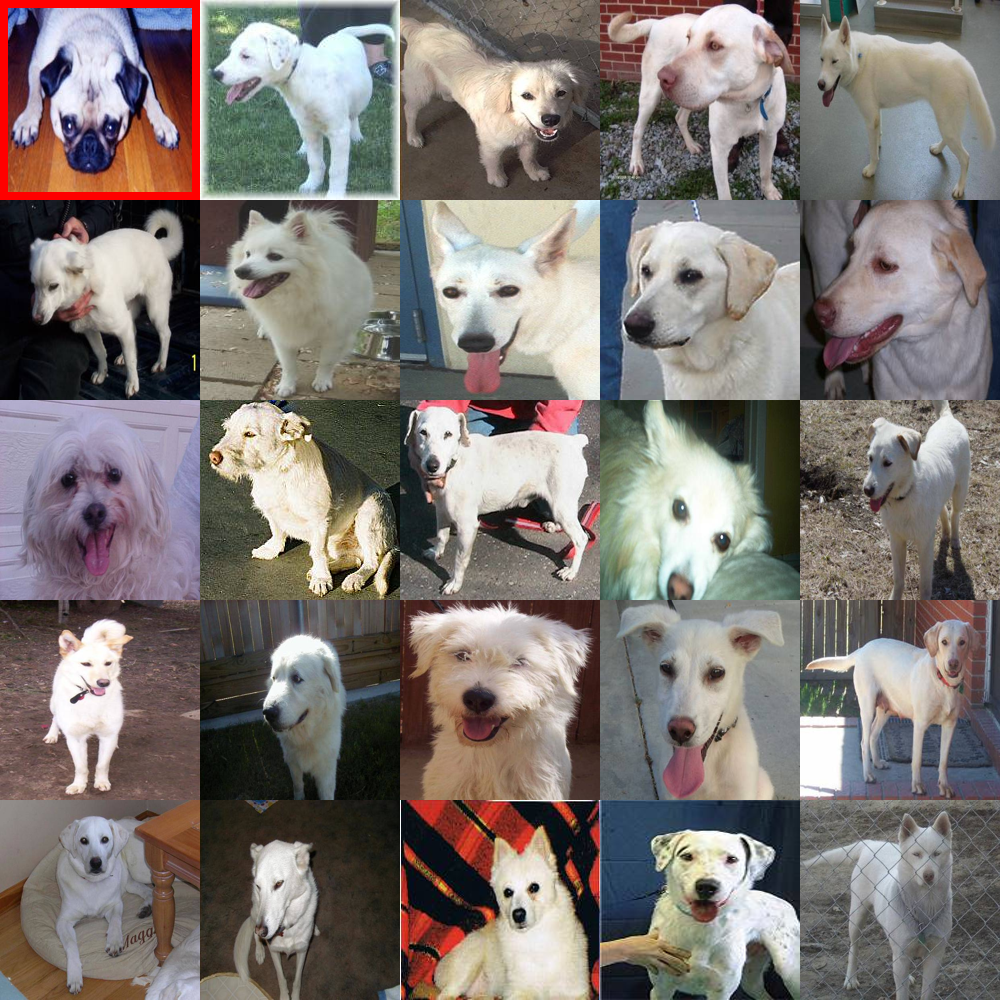

In [ ]:
#image
test_image_path = './dog-cat-dataset/data/test/dogs/dog.10445.jpg'
test_image = Image.open(test_image_path)
test_image_input = load_image(test_image_path, 384)

#caption
# test_caption = '2 cats'
# test_caption = '3 cats'

# test_caption = '2 dogs'
test_caption = 'white dog'

text_feature = model(test_image_input, test_caption, match_head = 'text')[0]

index_image = index.get_nns_by_vector(text_feature, 24)

image_grid = Image.new('RGB', (1000, 1000))

test_image = test_image.resize((200, 200))
image_draw = ImageDraw.Draw(test_image)
image_draw.rectangle([(0, 0), (199, 199)], outline = 'red', width = 8)
image_grid.paste(test_image, ((0, 0)))

for j in range(24):
  search_image = Image.open(list_image_path[index_image[j]])
  search_image = search_image.resize((200, 200))
  image_grid.paste(search_image, ((200*((j+1)%5), 200*((j+1)//5) )))

display(image_grid)